# The cooling_flow package

In [Stern et al. (2019a)](http://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2549S) and [Stern et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.492.6042S/abstract) we demonstrated that the volume-filling gas phase in dark matter halos converges onto a one-parameter family of solutions, assuming ongoing heating by feedback is negligible. 
The cooling_flow package derives these solutions by integrating the spherical, steady-state flow equations for radiatively-cooling gas in a constant background potential. These solutions can thus be useful for:
* Estimating halo gas structure between feedback bursts or after feedback has died out at low redshift
* As a benchmark for estimating the effects of feedback on halo gas in observations and simulations
* Initial conditions for simulations of halo gas
* Other systems with similar conditions, such as the center of elliptical galaxies (e.g. Quataert & Narayan 2000). 

The package integrates two types of solutions -- transonic solutions with an outer subsonic flow and an inner supersonic flow, and a purely subsonic flow which stalls at the radius of rotational support (the 'circularization radius'). Details of the methodology, physical motivation and reasoning behind these integrations are described in the above papers. Please send any questions or suggestions to sternjon@tauex.tau.ac.il

_Jonathan Stern_

## A. Installation
* Download using `git clone https://jonathanstern@bitbucket.org/jonathanstern/cooling_flow.git`
* After cloning, you can interactively walk through this Python notebook (e.g. `jupyter-lab example.ipynb`)
* Required libraries: numpy, scipy, astropy

## B. Integration

In [1]:
import sys
from astropy import units as un, constants as cons
import numpy as np

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
sys.path.append('../pysrc/') #assuming notebook run from ipynb/ directory 
import cooling_flow as CF

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


#### 1. define potential

In [3]:
# any class which inherits CF.Potential and implements the base class methods can be used as a potential
# several examples are implemented in the module HaloPotential
# this example initializes the potential to a power-law with v_c = 200*(r/R_vir)^-0.2
import HaloPotential as Halo
potential = Halo.PowerLaw(m=-0.1,vc_Rvir=150*un.km/un.s,Rvir=200*un.kpc)

#### 2. define cooling function

In [4]:
# any class which inherits CF.Cooling and implements the base class methods can be used as cooling function
# WiersmaCooling tables are implemented in the module WiersmaCooling (requires h5py)
import WiersmaCooling as Cool
Z2Zsun = 1/3.
z = 0.
cooling = Cool.Wiersma_Cooling(Z2Zsun,z)

/mnt/home/btan1/Work/CGM_ICs/ipynb/../pysrc/WiersmaCooling.py:53: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)


#### 3a. integrate transonic solution

In [5]:
max_step = 0.1                         #lowest resolution of solution in ln(r)
R_min    = 0.1*un.kpc                  #inner radius of supersonic part of solution
R_max    = 10.*potential.Rvir          #outer radius of integration
R_sonics  = np.array([1.,30.])*un.kpc  #sonic radii
transsonic_solutions = []
for R_sonic in R_sonics:
    print('R_sonic = %s'%R_sonic)
    transsonic_solutions.append(CF.shoot_from_sonic_point(potential,
                                                    cooling,
                                                    R_sonic,
                                                    R_max,
                                                    R_min,
                                                    max_step=max_step,
                                                    pr=True))
                        

R_sonic = 1.0 kpc
Integrated with v_c^2/c_s^2 (R_sonic) =1.000010;  maximum r=3 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.500005;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.250008;  maximum r=12 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.375006;  maximum r=88 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.437506;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.406256;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.390631;  maximum r=58 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.382819;  maximum r=150 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.386725;  maximum r=300 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.388678;  maximum r=1159 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.387701;  maximum r=499 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic

#### 3b. integrate solution which stalls at circularization radius

In [6]:
max_step = 0.1                             #lowest resolution of solution in ln(r)
R_circ   = 0.05 * potential.Rvir           #circularization radius
R_max    = 10.  * potential.Rvir           #outer radius of integration
Mdots  = np.array([1.,50.])*un.Msun/un.yr  # mass inflow rates
stalled_solutions = []
for Mdot in Mdots:
    print('Mdot = %s'%Mdot)
    stalled_solutions.append( CF.shoot_from_R_circ(potential,
                                                   cooling,
                                                   R_circ,
                                                   Mdot,
                                                   R_max,
                                                   max_step=max_step,
                                                   pr=True))

Mdot = 1.0 solMass / yr
Integrated with log T(R_circ)=4.50, maximum radius reached 49 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.75, maximum radius reached 175 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.62, maximum radius reached 226 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.69, maximum radius reached 449 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.66, maximum radius reached 875 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.67, maximum radius reached 1999 kpc, stop reason: max R reached
Mdot = 50.0 solMass / yr
Integrated with log T(R_circ)=4.50, maximum radius reached 25 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.25, maximum radius reached 53 kpc, stop reason: unbound


/Users/jonathanstern/Dropbox/github_repositories/CGM_ICs/ipynb/../pysrc/cooling_flow.py:157: RuntimeWarning: overflow encountered in double_scalars
  rho,T=e**ln_rho*un.g/un.cm**3, e**ln_T*un.K
/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jonathanstern/Dropbox/github_repositories/CGM_ICs/ipynb/../pysrc/WiersmaCooling.py:59: RuntimeWarning: divide by zero encountered in log10
  return self.f_Cooling((log(T.to('K').value), log(nH.to('cm**-3').value))) * un.erg*un.cm**3/un.s
/Users/jonathanstern/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:2546: RuntimeWarni

Integrated with log T(R_circ)=4.12, maximum radius reached 149 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.06, maximum radius reached 12 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.09, maximum radius reached 14 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.11, maximum radius reached 252 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.10, maximum radius reached 904 kpc, stop reason: unbound
Integrated with log T(R_circ)=4.10, maximum radius reached 65 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.10, maximum radius reached 385 kpc, stop reason: sonic point
Integrated with log T(R_circ)=4.10, maximum radius reached 1999 kpc, stop reason: max R reached


## C. Plotting

In [7]:
import pylab as pl
import matplotlib
# some figure definitions
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=12)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True

AttributeError: 'IntegrationResult' object has no attribute 'vr'

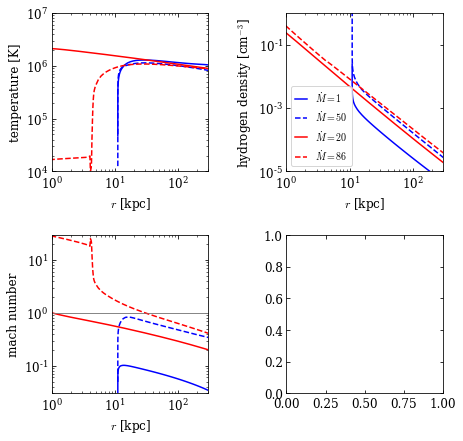

In [8]:
fig = pl.figure(figsize=(7,7))
pl.subplots_adjust(hspace=0.4,wspace=0.5)
for iPanel in range(4):
    pl.subplot(2,2,iPanel+1)
    for ires,res in enumerate(stalled_solutions+transsonic_solutions):
        c= 'br'[ires//2]
        ls = ('-','--')[ires%2]
        label = r'$\dot{M} = %d$'%res.Mdot.value
        if iPanel==0: ys = res.Ts()
        if iPanel==1: ys = res.nHs()
        if iPanel==2: ys = res.Ms()
        if iPanel==3: ys = res.t_cools() / res.t_flows()
        pl.loglog(res.Rs(),ys,c=c,ls=ls,label=label)
        pl.xlim(1,300)
        pl.xlabel(r'$r$ [kpc]')
        if iPanel==0:
            pl.ylabel(r'temperature [K]')
            pl.ylim(1e4,1e7)            
        if iPanel==1: 
            pl.ylabel(r'hydrogen density [cm$^{-3}$]')
            pl.ylim(1e-5,1)
            pl.legend(loc='lower left',fontsize=10,handlelength=1.2)
        if iPanel==2: 
            pl.ylabel(r'mach number')
            pl.ylim(0.03,30)
            pl.axhline(1.,c='.5',lw=0.5)
        if iPanel==3: 
            pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
            pl.ylim(0.03,30)
            pl.axhline(1.,c='.5',lw=0.5)

In [9]:
import pdb

In [ ]:
pdb.pm()

> /Users/jonathanstern/Dropbox/github_repositories/CGM_ICs/pysrc/cooling_flow.py(649)t_flows()
    647     def t_flows(self):
    648         """flow times (r/v) of the solution at all radii"""
--> 649         return (self.Rs()/self.vr()).to('Gyr')
    650     def t_cools(self):
    651         """cooling times of the solution at all radii"""

ipdb> p self.vs()
<Quantity [ 0.82644628,  1.0875759 ,  1.35774206,  1.61934593,  1.87457435,
            2.08065153,  2.35559862,  2.67719827,  3.10863319,  3.52312792,
            4.09812703,  4.55629709,  5.01250819,  5.69097504,  6.09673778,
            6.5810598 ,  7.09178603,  7.59365385,  8.36302359,  9.41579389,
           10.74114651, 11.77074777, 12.73838011, 13.67327859, 14.81390899,
           15.46041222, 15.86689307, 15.91938563, 15.77276375, 15.5071849 ,
           15.16805917, 14.78316466, 14.3695325 , 13.93814441, 13.49633921,
           13.04963021, 12.6009667 , 12.15175792, 11.70354334, 11.25919054,
           10.82137811, 10.3